In [ ]:
!pip install -q clu

In [ ]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [1]:
from functools import partial
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

import torch

from dataclasses import dataclass

from typing import Union

import matplotlib.pyplot as plt
import seaborn

from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from tqdm import tqdm

In [2]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [4]:
# create a mapping from characters to integers
stoi = { ch: i for i,ch in enumerate(chars) }
itos = { i: ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [5]:
data = jnp.array(encode(text), dtype=jnp.int32)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

(1115394,) int32
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1 39 56 43  1 39 50 50  1 56 43 57 53 50 60 43 42  1 56 39
 58 46 43 56  1 58 53  1 42 47 43  1 58 46 39 52  1 58 53  1 44 39 51 47
 57 46 12  0  0 13 50 50 10  0 30 43 57 53 50 60 43 42  8  1 56 43 57 53
 50 60 43 42  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 18 47
 56 57 58  6  1 63 53 59  1 49 52 53 61  1 15 39 47 59 57  1 25 39 56 41
 47 59 57  1 47 57  1 41 46 47 43 44  1 43 52 43 51 63  1 58 53  1 58 46
 43  1 54 43 53 54 50 43  8  0  0 13 50 50 10  0 35 43  1 49 52 53 61  5
 58  6  1 61 43  1 49 52 53 61  5 58  8  0  0 18 47 56 57 58  1 15 47 58
 47 64 43 52 10  0 24 43 58  1 59 57  1 49 47 50 50  1 46 47 51  6  1 39
 52 42  1 61 43  5 50 50  1 46 39 

In [6]:
train_test_split = 0.9
n = int(train_test_split*len(data))
train_data = data[:n]
test_data = data[n:]

In [7]:
block_size = 8
train_data[:block_size+1]

Array([18, 47, 56, 57, 58,  1, 15, 47, 58], dtype=int32)

In [8]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [18] the target: 47
when input is [18 47] the target: 56
when input is [18 47 56] the target: 57
when input is [18 47 56 57] the target: 58
when input is [18 47 56 57 58] the target: 1
when input is [18 47 56 57 58  1] the target: 15
when input is [18 47 56 57 58  1 15] the target: 47
when input is [18 47 56 57 58  1 15 47] the target: 58


In [9]:
batch_size = 128 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 1000
eval_interval = 1000
learning_rate = 5e-4
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
expans = 2
n_heads = 1
channel_size = n_embd // n_heads
n_layers = 2
dropout = 0.2
conv_k_size = 3
n_latent_dim = 16

rng_key = jax.random.PRNGKey(1564)

dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(None, 0, None))

@jax.jit
def get_batch(random_key, data):
    """Prepares a random batch of training data.

    Args:
      random_key: A random seed for sampling a batch.
      data: The complete training dataset.

    Returns:
      x: Input sequences.
      y: Target sequences (shifted inputs).
    """
    ix = jax.random.randint(
      random_key, shape=(batch_size, 1), minval=0, maxval=len(data) - block_size
    )
    x = dynamic_slice_vmap(data, ix, (block_size,))
    y = dynamic_slice_vmap(data, ix + 1, (block_size,))
    return x, y

xb, yb = get_batch(rng_key, train_data)
train_shape = xb.shape
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

# print('----')

# for b in range(batch_size): # batch dimension
#     for t in range(block_size): # time dimension
#         context = xb[b, :t+1]
#         target = yb[b,t]
#         print(f"when input is {context} the target: {target}")

inputs:
(128, 256)
[[13 30 15 ... 26 19 20]
 [63 53 59 ... 64 39 56]
 [10  0 32 ... 52 53 47]
 ...
 [42  6  0 ... 43 43  1]
 [63  1 39 ...  6  1 61]
 [ 1 54 56 ... 50 47 41]]
targets:
(128, 256)
[[30 15 20 ... 19 20 13]
 [53 59 52 ... 39 56 42]
 [ 0 32 46 ... 53 47 52]
 ...
 [ 6  0 14 ... 43  1 44]
 [ 1 39 57 ...  1 61 53]
 [54 56 47 ... 47 41 39]]


In [10]:
class RMSNorm(nn.Module):
    d_model: int
    eps: float = 1e-5

    @nn.compact
    def __call__(self, x):
        weight = self.param('weight', nn.initializers.ones, (self.d_model,)) # TODO, maybe use setup will be more clear
        normed = x * jax.lax.rsqrt(np.mean(np.square(x), axis=-1, keepdims=True) + self.eps)
        output = normed * weight
        return output

In [11]:
xb.shape

(128, 256)

In [12]:
class Expan_proj(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=n_embd)(x)
        return x
    
in_proj = nn.Dense(features=n_embd)
params = in_proj.init(rng_key, xb)
in_proj.apply(params, xb).shape

(128, 384)

In [13]:
jax.tree_util.tree_map(lambda x: x.shape, params)

{'params': {'bias': (384,), 'kernel': (256, 384)}}

# Mamba Block
Dense --> Conv1D --> Silu --> SSM --> Silu -->

In [21]:
class MambaBlock(nn.Module):
    
    def setup(self):
        emb_features = n_embd * expans
        self.in_proj1 = nn.Dense(features=emb_features)
        self.in_proj2 = nn.Dense(features=emb_features)
        
        # Adjusted for Flax. Flax does not have nn.Conv1d, so you might need to reshape or use a different approach
        self.conv1d = nn.Conv(features=emb_features,
                              kernel_size=conv_k_size,
                              padding=1,
                              )

        self.A = -1*self.param('A', nn.initializers.ones, (1, n_latent_dim, emb_features, 1))
        self.B = self.param('B', nn.initializers.ones, (1, n_latent_dim, 1, block_size))
        self.C = self.param('C', jax.random.normal, (1, n_latent_dim, 1, block_size))
#         self.D = self.param('D', jax.random.normal, (1, self.args.d_state, self.args.d_model, 1))
        self.delta = self.param('delta', jax.random.normal, (1, 1,emb_features, block_size))
        
        self.out_proj = nn.Dense(n_embd // n_heads)
        
#         self.rms_norm = nn.RMSNorm()
        
    def __call__(self, embeds):

        x = self.in_proj1(embeds)
        x = self.conv1d(x)
        x = jax.nn.silu(x)
        x = x.reshape((x.shape[0],1,x.shape[2],x.shape[1]))
        x = self.ssm(x)[1]
        x = x.reshape((x.shape[0],x.shape[3],x.shape[2]))
        x = x*jax.nn.silu(self.in_proj2(embeds))

        x = self.out_proj(x)
        
#         x = self.rms_norm(x)
        
        return x
    def discretize(self):
        da = self.delta * self.A
        a_ = jnp.exp(da)
        b_ = self.C * self.delta
        return a_, b_

    def ssm(self, x):
        y = []
        h = 0
        a_, b_ = self.discretize()
        for k in range(x.shape[-1]):
            h = a_[..., k] * h + b_[..., k] * x[..., k]
            y.append((self.C[..., k] * h).sum(1, keepdims=True))
        return h, jnp.stack(y, -1)

In [22]:
# model = MambaBlock()
# params = model.init(jax.random.key(0), xb)
# print(model.tabulate(jax.random.key(0), xb,
#                    compute_flops=True, compute_vjp_flops=True))
# xs = model.apply(params, xb)
# xb.shape, xs.shape

In [23]:
class MultiHeadMamba(nn.Module):
    def setup(self):
        self.heads = [MambaBlock() for _ in range(n_heads)]
        self.rms_norm = nn.RMSNorm()
        
    def __call__(self, x):
        out = jnp.concatenate([h(x) for h in self.heads], axis=-1)
        x = self.rms_norm(out)
        return x

In [24]:
class Mamba(nn.Module):
    
    def setup(self):
        self.tok_embeddings = nn.Embed(vocab_size, n_embd)
        self.pos_embeddings = nn.Embed(block_size, n_embd)

        
        self.mamba_layers = [MultiHeadMamba() for _ in range(n_layers)]
        
        self.preds_out = nn.Dense(vocab_size)
        
    def __call__(self, x):
        x = self.tok_embeddings(x) + self.pos_embeddings(jnp.arange(block_size))
        
        for layer in self.mamba_layers:
            x = layer(x)
            
        out = self.preds_out(x)
#         out = self.tok_embeddings.attend(x)
        return out
    
    @jax.jit
    def generate(self, idx, max_new_tokens, params):
    # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self.apply(params, idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            ##probs = tf.keras.activations.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = jax.random.categorical(jax.random.PRNGKey(52), logits) # (B, 1)
            # append sampled index to the running sequence
            idx = jax.numpy.expand_dims(jnp.concatenate([idx[0], idx_next], axis=0), 0) # (B, T+1)
    #         print(idx_next)
    #         print(idx)

        return idx

In [25]:
# test_model = Mamba()
# test_params = test_model.init(jax.random.key(42), xb)
# n_params = sum(p.size for p in jax.tree_util.tree_leaves(test_params))
# print(f"Total number of parameters: {n_params:_}")
# # print(fin_model.tabulate(jax.random.key(42), xb,
# #                    compute_flops=True, compute_vjp_flops=True))
# xf = test_model.apply(test_params, xb)
# xb.shape, xf.shape

In [26]:
# class NanoLM(nn.Module):
#     """NanoLM model."""
#     vocab_size: int = 65
#     num_layers: int = 6
#     num_heads: int = 8
#     head_size: int = 32
#     dropout_rate: float = 0.2
#     embed_size: int = 256
#     block_size: int = 64

#     @nn.compact
#     def __call__(self, x, training: bool):
#         seq_len = x.shape[1]

#         x = nn.Embed(self.vocab_size, self.embed_size)(x) + nn.Embed(
#             self.block_size, self.embed_size
#         )(jnp.arange(seq_len))
#         for _ in range(self.num_layers):
#             x_norm = nn.LayerNorm()(x)
#             x = x + nn.MultiHeadDotProductAttention(
#               num_heads=self.num_heads,
#               qkv_features=self.head_size,
#               out_features=self.head_size * self.num_heads,
#               dropout_rate=self.dropout_rate,
#             )(
#               x_norm,
#               x_norm,
#               mask=jnp.tril(jnp.ones((x.shape[-2], x.shape[-2]))),
#               deterministic=not training,
#             )

#             x = x + nn.Sequential([
#               nn.Dense(4 * self.embed_size),
#               nn.relu,
#               nn.Dropout(self.dropout_rate, deterministic=not training),
#               nn.Dense(self.embed_size),
#             ])(nn.LayerNorm()(x))

#         x = nn.LayerNorm()(x)
#         return nn.Dense(self.vocab_size)(x)

In [27]:
fin_model = Mamba()
fin_params = fin_model.init(jax.random.key(42), xb)
n_params = sum(p.size for p in jax.tree_util.tree_leaves(fin_params))
print(f"Total number of parameters: {n_params:_}")
# print(fin_model.tabulate(jax.random.key(42), xb,
#                    compute_flops=True, compute_vjp_flops=True))
xf = fin_model.apply(fin_params, xb)
xb.shape, xf.shape

Total number of parameters: 3_022_657


((128, 256), (128, 256, 65))

In [28]:
n_embd * expans

768

In [29]:
# token_gen = generate(jnp.zeros((1,1)).astype(jnp.int32), 100, fin_model, fin_params)
# print(token_gen)
# print(decode(token_gen[0].tolist()))

In [30]:
jax.random.categorical(jax.random.PRNGKey(5332), 1000.0*xf[1][-1][:])

Array(63, dtype=int32)

In [31]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [32]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, rng, learning_rate, train_shape):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones(train_shape).astype(jnp.int32))['params'] # initialize parameters by passing a template image
    tx = optax.adamw(learning_rate)
    return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty(),
    )

In [33]:
@jax.jit
def train_step(state, inputs, targets):
    """Train for a single step."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, inputs)
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=targets).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [34]:
@jax.jit
def compute_metrics(*, state, inputs, targets):
    logits = state.apply_fn({'params': state.params}, inputs)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=targets).mean()
    metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=targets, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [35]:
num_epochs = 10
learning_rate = 0.005
init_rng = jax.random.key(0)

In [36]:
state = create_train_state(fin_model, init_rng, learning_rate, train_shape)
del init_rng  # Must not be used anymore.

In [37]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [38]:
SEED = 442
key = jax.random.PRNGKey(SEED)
for step in tqdm(range(max_iters)): # increase number of steps for good results... 
    
      # sample a batch of data
    xb, yb = get_batch(key, train_data)
    state = train_step(state, xb, yb)
    state = compute_metrics(state=state, inputs=xb, targets=yb)
    
    key = (jax.random.split(key)[0])
    
    if step == 0 or (step+1) % 100 == 0: # one training epoch has passed
        for metric,value in state.metrics.compute().items(): # compute metrics
            metrics_history[f'train_{metric}'].append(value) # record metrics
        state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

        # Compute metrics on the test set after each training epoch
        test_state = state
        x_test, y_test = get_batch(key, test_data)
    #     for test_batch in test_ds.as_numpy_iterator():
        test_state = compute_metrics(state=test_state, inputs=x_test, targets=y_test)

        for metric,value in test_state.metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)

        print(f"train epoch: {(step+1)}, "
              f"loss: {metrics_history['train_loss'][-1]}, "
              f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
        print(f"test epoch: {(step+1) }, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

  0%|          | 1/1000 [01:54<31:54:20, 114.98s/it]

train epoch: 1, loss: 4.2607526779174805, accuracy: 6.55517578125
test epoch: 1, loss: 4.329971790313721, accuracy: 5.682373046875


 10%|█         | 100/1000 [02:39<17:04,  1.14s/it]  

train epoch: 100, loss: 1.1608117818832397, accuracy: 69.78096771240234
test epoch: 100, loss: 0.3033609390258789, accuracy: 93.096923828125


 20%|██        | 200/1000 [03:23<15:10,  1.14s/it]

train epoch: 200, loss: 0.26103976368904114, accuracy: 94.15106201171875
test epoch: 200, loss: 0.2693251967430115, accuracy: 93.9666748046875


 30%|███       | 300/1000 [04:08<13:21,  1.14s/it]

train epoch: 300, loss: 0.29715389013290405, accuracy: 93.2879638671875
test epoch: 300, loss: 0.31120023131370544, accuracy: 92.7947998046875


 40%|████      | 400/1000 [04:52<11:21,  1.14s/it]

train epoch: 400, loss: 0.2853522300720215, accuracy: 93.34222412109375
test epoch: 400, loss: 0.2764747738838196, accuracy: 93.414306640625


 50%|█████     | 500/1000 [05:36<09:29,  1.14s/it]

train epoch: 500, loss: 0.2712746560573578, accuracy: 93.43611907958984
test epoch: 500, loss: 0.267510324716568, accuracy: 93.51806640625


 60%|██████    | 600/1000 [06:21<07:34,  1.14s/it]

train epoch: 600, loss: 0.2804121971130371, accuracy: 93.20693969726562
test epoch: 600, loss: 0.3765065371990204, accuracy: 90.88134765625


 70%|███████   | 700/1000 [07:05<05:41,  1.14s/it]

train epoch: 700, loss: 0.31298381090164185, accuracy: 92.19677734375
test epoch: 700, loss: 0.2749432325363159, accuracy: 93.0419921875


 80%|████████  | 800/1000 [07:49<03:47,  1.14s/it]

train epoch: 800, loss: 0.27303221821784973, accuracy: 93.10464477539062
test epoch: 800, loss: 0.2746090292930603, accuracy: 93.07861328125


 90%|█████████ | 900/1000 [08:34<01:54,  1.14s/it]

train epoch: 900, loss: 0.27219313383102417, accuracy: 93.0968017578125
test epoch: 900, loss: 0.27479445934295654, accuracy: 93.121337890625


100%|██████████| 1000/1000 [09:18<00:00,  1.79it/s]

train epoch: 1000, loss: 0.27054688334465027, accuracy: 93.11099243164062
test epoch: 1000, loss: 0.2750835418701172, accuracy: 93.02978515625


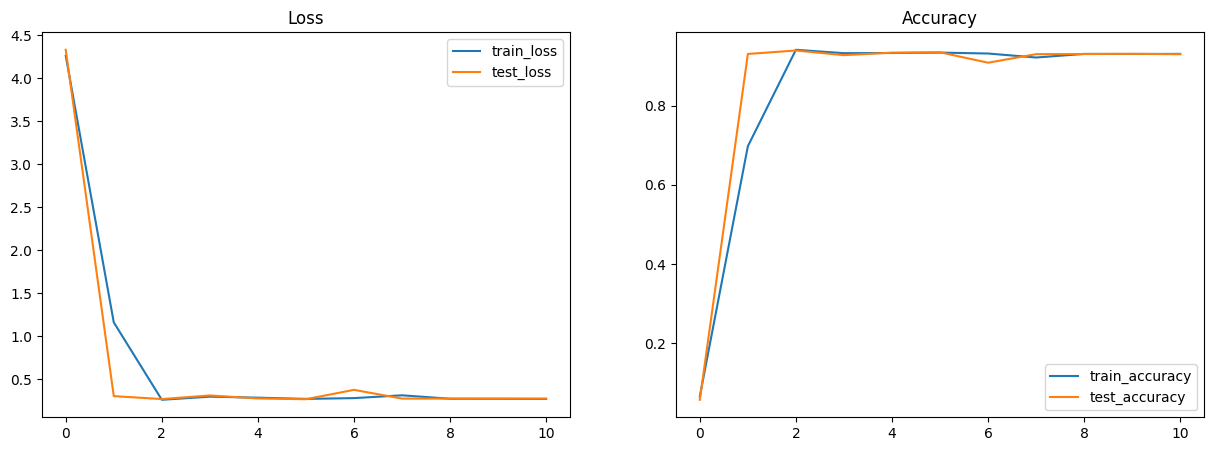

<Figure size 640x480 with 0 Axes>

In [39]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [40]:

logits = fin_model.apply(fin_params, xb)
loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=yb).mean()

print(loss)

4.6668487


In [41]:
# def generate_text(idx, max_new_tokens, params):
# # idx is (B, T) array of indices in the current context
#     for i in range(max_new_tokens):
#         # crop idx to the last block_size tokens
#         idx_cond = idx[:, -block_size:]
#         # get the predictions
#         logits = fin_model.apply(params, idx_cond)
#         # focus only on the last time step
#         logits = logits[:, -1, :] # becomes (B, C)

#         if i == 0:
#             rng, rng_subkey = jax.random.split(jax.random.PRNGKey(12))
#         else:
#             rng, rng_subkey = jax.random.split(rng)
            
#         idx_next = jax.random.categorical(rng_subkey, logits, axis=-1, shape=(1, 1)) # (B, 1)

        
#         # append sampled index to the running sequence
#         idx = jnp.concatenate([idx, idx_next], axis=-1) # (B, T+1)

#     return idx

In [42]:
@partial(jax.jit, static_argnames=("self", "length"))
def generate_text(rng, params, length):
    def _scan_generate(carry, _):
        random_key, context = carry
        logits = fin_model.apply(params, context)
        rng, rng_subkey = jax.random.split(random_key)
        new_token = jax.random.categorical(
          rng_subkey, logits[:, -1, :], axis=-1, shape=(1, 1)
        )
        context = jnp.concatenate([context[:, 1:], new_token], axis=1)
        return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
    _scan_generate,
    (rng, jnp.zeros((1, block_size), dtype=jnp.int32)),
    (),
    length=length,
    )
    return new_tokens

/opt/conda/lib/python3.10/site-packages/jax/_src/api_util.py:231: SyntaxWarning: Jitted function has invalid argnames {'self'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


In [43]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(156))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
token_gen = generate_text(key, {'params': state.params}, new_tokenz)[:, 0, 0].tolist()
print(token_gen)
print(decode(token_gen))

[24, 53, 56, 50, 6, 1, 51, 53, 5, 58, 46, 53, 50, 52, 1, 52, 53, 42, 1, 57, 46, 53, 60, 50, 47, 60, 47, 52, 1, 41, 56, 50, 59, 50, 50, 0, 13, 58, 46, 39, 56, 43, 1, 39, 52, 2, 0, 32, 46, 43, 58, 1, 43, 44, 1, 59, 54, 58, 46, 43, 8, 0, 1, 56, 39, 41, 1, 63, 39, 56, 56, 42, 1, 21, 1, 5, 54, 43, 57, 14, 53, 59, 58, 0, 25, 63, 1, 41, 53, 41, 58, 39, 41, 43, 0, 30, 21, 37, 50, 50, 39, 57, 43, 50, 50, 43, 39, 57, 1, 40, 53, 51, 43, 1, 58, 53, 1, 58, 46, 46, 1, 61, 46, 52, 42, 1, 39, 59, 58, 1, 21, 43, 57, 1, 21, 1, 53, 44, 1, 58, 56, 50, 49, 1, 59, 58, 43, 42, 8, 0, 0, 19, 30, 21, 30, 10, 0, 16, 39, 58, 46, 43, 60, 43, 52, 58, 46, 43, 52, 42, 1, 47, 41, 46, 1, 58, 46, 43, 58, 1, 58, 46, 39, 58, 43, 42, 1, 40, 59, 40, 43, 1, 50, 43, 1, 51, 39, 2, 0, 15, 47, 52, 45, 40, 43, 1, 58, 53, 59, 1, 52, 43, 6, 1, 41, 47, 50, 1, 58, 53, 59, 56, 57, 58, 1, 58, 46, 43, 8, 0, 0, 34, 43, 1, 53, 59, 56, 57, 58, 46, 43, 58, 14, 33, 37, 17, 5, 6, 1, 39, 42, 1, 57, 53, 52, 42, 1, 57, 59, 47, 56, 42, 6, 1, 52, 

In [44]:
print(decode(token_gen))

Lorl, mo'tholn nod shovlivin crlull
Athare an!
Thet ef upthe.
 rac yarrd I 'pesBout
My coctace
RIYllaselleas bome to thh whnd aut Ies I of trlk uted.

GRIR:
Datheventhend ich thet thated bube le ma!
Cingbe tou ne, cil tourst the.

Ve oursthetBUYE', ad sond suird, nou prer th thar beelleat I gowd war yong codthun dsd:
I Yoy dra mam,
Iy lee thafI pownanceteld, wace, pratham atbes
I Goperron?

Pate, whe my yasd then,
UIRDEOd woucen.

IE' LARO:
AMy towtlar'nny dret shcenod psd youm ris.

Yut se sr mascrl thr lound bournicer dry cour b th naly th mar thatrol, tah, dongeths the a pong fonell sor the rond ar fous irhs breat s sas noug prell wat' pas'thpy ye yeghukies
Whrle sh.
Thaple pis yront thlay,
O nand sr mapILI the thawe dat thamenbln Thes Tout IX:
Owplecf th daf trime.

Yod, yows, Thal.
Bug, towedlecenge dalul.

Dy thee.

ILCAMCD:
of whmitowsour farn, thleide thaarlllethapfe, Path thd fon antce ret bemes be, whall I th?

JUR:
RUM sor! whe Thy me na'euchl punth mall prntewn If dord 's
S

In [45]:
att_model = NanoLM(
    vocab_size=vocab_size,
    num_layers=4,
    num_heads=8,
    head_size=32,
    dropout_rate=0.2,
    embed_size=256,
    block_size=64,
)

var_params = att_model.init(
    key,
    jnp.ones((batch_size, block_size), dtype=jnp.int32),
    training=False,
)

n_params = sum(p.size for p in jax.tree_util.tree_leaves(var_params))

print(f"Total number of parameters: {n_params:_}")

NameError: name 'NanoLM' is not defined

In [ ]:
jax.random.categorical(jax.random.PRNGKey(100), jnp.array([10.0,-10.0,-10.0,10.0,-11.0,-11.0,-11.0,-100.0,-1000]))

In [ ]:
logitss = state.apply_fn({'params': state.params}, (43*jnp.zeros((1,1))).astype(jnp.int32))[:,-1,:]

In [ ]:
token_gen[:,-32:]

In [ ]:
print("gen text: ",print(decode(token_gen[0].tolist())), "end of text")

In [ ]:
jax.random.randint(jax.random.PRNGKey(52), (1,32), minval, maxval

In [ ]:
import torch
from torch.nn import functional as F
import numpy as np

logitss = state.apply_fn({'params': state.params}, xbb[0].reshape(1,32))[:,-1,:]

probs = F.softmax(torch.from_numpy(np.asarray(logitss)), dim=-1) # (B, C)
# sample from the distribution
idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
idx_next

In [ ]:
state.tx.